In [1]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
pio.templates.default = "plotly_white"
import pandas as pd
pd.set_option("display.max_columns",30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from tqdm.autonotebook import tqdm
from IPython.display import display, HTML
import warnings
# %load_ext autoreload
# %autoreload 2
np.random.seed()
tqdm.pandas()

/var/folders/8p/5_r5jcmx2sl549t8tgwqvr3c0000gn/T/ipykernel_16518/3864846299.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def format_plot(
    fig, 
    legends = None, 
    xlabel="Time", 
    ylabel="Value", 
    figsize=(500,900), 
    font_size=15, 
    title_font_size=20
):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=figsize[1],
            height=figsize[0],
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

The purpose of this notebook is to understand the task at hand, the dataset has a number of different features where a date column exists, so the goal will be to check whether to tackle the problem as a regression task or a time series task

In [3]:
df = pd.read_csv("Data/interview_dataset.csv")
print(df.shape)
df.head()

(1000, 28)


treatment company  azimuth  md (ft)  tvd (ft) date on production  \
0  treatment company 1  -32.280    19148  6443.000           3/1/2018   
1  treatment company 2  -19.800    15150  7602.000           7/1/2014   
2  treatment company 3  -26.880    14950  5907.000           8/1/2018   
3  treatment company 4  -49.100    11098  6538.000           1/1/2012   
4  treatment company 5    5.560    10549  7024.000           1/1/2012   

     operator  footage lateral length  well spacing  porpoise deviation  \
0  operator 1               11966.000      4368.463               6.330   
1  operator 2                6890.000      4714.992               1.280   
2  operator 1                8793.000       798.921               2.030   
3  operator 1                4234.000           NaN               6.000   
4  operator 3                2972.000      2967.563              11.870   

   porpoise count  shale footage  acoustic impedance  log permeability  \
0              12           1093           30123.200             0.680   
1               4              0           30951.610             1.850   
2               6           3254           28900.250             0.290   
3              23           7470           32826.080             0.730   
4               9           3637           26740.050             0.470   

   porosity  poisson ratio  water saturation   toc   vcl  p-velocity  \
0     0.020          0.340             0.850 5.000 0.420   13592.230   
1     0.170          0.190             0.690 4.220 0.740   11735.040   
2     0.020          0.330               NaN 4.690 0.610   13227.810   
3     0.030          0.200               NaN 4.400 0.560   12646.340   
4     0.020          0.330             0.800 4.660 0.580   13192.180   

   s-velocity  youngs modulus     isip  breakdown pressure  pump rate  \
0    6950.440          30.820 4149.000                 NaN         83   
1    7162.450          29.720 5776.000                 NaN        102   
2    6976.930          30.990 4628.000                 NaN         88   
3    6799.370          26.200 4582.000                 NaN        100   
4    7046.910          31.180 4909.000                 NaN         94   

   total number of stages  proppant volume  proppant fluid ratio  production  
0                      56     21568792.000                 1.230    5614.948  
1                      33      9841307.000                 1.470    2188.837  
2                      62     17116240.000                 1.670    1450.033  
3                      11      3749559.000                 0.770    1060.764  
4                       9      6690705.000                 1.320     607.530

In [4]:
df["date on production"] = pd.to_datetime(df["date on production"], format = "%d/%m/%Y")
df = df.sort_values("date on production").reset_index(drop = True)
df.head()

treatment company  azimuth  md (ft)  tvd (ft) date on production  \
0  treatment company 12  -18.630    12593  8178.000         2011-01-01   
1  treatment company 28  -17.320    11026  7160.000         2011-01-01   
2   treatment company 1  -30.220    14390  8012.000         2011-01-01   
3   treatment company 8  -40.880    11000  6217.000         2011-01-01   
4   treatment company 2  -10.840    12095  5907.000         2011-01-01   

      operator  footage lateral length  well spacing  porpoise deviation  \
0   operator 2                4133.000           NaN              15.130   
1  operator 14                3315.000      3962.423              40.150   
2  operator 20                6050.000      2023.385               4.560   
3  operator 23                4663.000      4690.188              20.660   
4   operator 2                5511.000       947.213               3.210   

   porpoise count  shale footage  acoustic impedance  log permeability  \
0              19           9516           35039.020             0.320   
1               4              0           31372.340             0.140   
2              11           6588           34112.470             1.000   
3               1           1791           32718.750             0.390   
4              15           6596           34748.790             1.190   

   porosity  poisson ratio  water saturation   toc   vcl  p-velocity  \
0     0.020          0.340               NaN 4.680 0.620   13231.580   
1     0.030          0.250               NaN 4.890 0.590   11337.540   
2     0.060          0.290               NaN 6.080 0.420   11723.420   
3     0.020          0.330               NaN 4.720 0.580   13268.200   
4     0.100          0.190               NaN 6.290 0.500   12161.640   

   s-velocity  youngs modulus     isip  breakdown pressure  pump rate  \
0    6984.640          31.020 6209.000                 NaN         73   
1    6784.810          27.950 5612.000                 NaN         80   
2    7030.380          31.580 5964.000                 NaN         80   
3    7001.020          31.040 4567.000                 NaN         79   
4    7026.790          28.090 4466.000                 NaN         82   

   total number of stages  proppant volume  proppant fluid ratio  production  
0                      12      4256000.000                 1.320    1255.634  
1                      15              NaN                 1.180    4036.422  
2                      16      5624710.000                 1.230    1389.367  
3                      19      5590514.000                 1.070     245.225  
4                      16      6460784.000                 1.390    1202.435

# Check summary statistics and information on dataframe

In [5]:
df.describe().T

count                           mean  \
azimuth                 945.000                        -33.906   
md (ft)                1000.000                      13988.387   
tvd (ft)                980.000                       7103.620   
date on production         1000  2015-01-01 02:49:55.199999744   
footage lateral length 1000.000                       6387.050   
well spacing            844.000                       2223.227   
porpoise deviation     1000.000                         50.457   
porpoise count         1000.000                          9.443   
shale footage          1000.000                       3784.827   
acoustic impedance     1000.000                      33492.835   
log permeability       1000.000                          0.624   
porosity                881.000                          0.032   
poisson ratio          1000.000                          0.304   
water saturation        423.000                          0.789   
toc                     979.000                          4.619   
vcl                    1000.000                          0.629   
p-velocity             1000.000                      12766.714   
s-velocity             1000.000                       6933.582   
youngs modulus          981.000                         30.276   
isip                    923.000                       4965.485   
breakdown pressure      256.000                       7365.949   
pump rate              1000.000                         85.052   
total number of stages 1000.000                         28.815   
proppant volume         868.000                   10608800.756   
proppant fluid ratio   1000.000                          1.166   
production             1000.000                       1949.920   

                                        min                  25%  \
azimuth                             -87.250              -46.220   
md (ft)                            8642.000            12157.500   
tvd (ft)                           4859.000             6407.000   
date on production      2011-01-01 00:00:00  2013-01-07 00:00:00   
footage lateral length             1329.000             4668.000   
well spacing                        335.459             1084.525   
porpoise deviation                    0.030                4.660   
porpoise count                        0.000                4.000   
shale footage                         0.000                0.000   
acoustic impedance                26740.050            32718.460   
log permeability                     -0.030                0.310   
porosity                              0.000                0.020   
poisson ratio                         0.190                0.280   
water saturation                      0.220                0.735   
toc                                   1.630                4.515   
vcl                                   0.030                0.470   
p-velocity                        10631.340            12230.625   
s-velocity                         6374.620             6808.660   
youngs modulus                       25.640               29.720   
isip                               2149.000             4391.500   
breakdown pressure                 4364.000             6102.750   
pump rate                             2.000               77.000   
total number of stages                9.000               16.000   
proppant volume                  176096.000          6146848.500   
proppant fluid ratio                  0.030                0.950   
production                           76.107             1003.897   

                                        50%                  75%  \
azimuth                             -32.990              -22.580   
md (ft)                           13659.500            15468.000   
tvd (ft)                           6977.000             7820.000   
date on production      2015-01-04 00:00:00  2017-01-08 00:00:00   
footage lateral length             5927.000             7744.000  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   treatment company       1000 non-null   object        
 1   azimuth                 945 non-null    float64       
 2   md (ft)                 1000 non-null   int64         
 3   tvd (ft)                980 non-null    float64       
 4   date on production      1000 non-null   datetime64[ns]
 5   operator                1000 non-null   object        
 6   footage lateral length  1000 non-null   float64       
 7   well spacing            844 non-null    float64       
 8   porpoise deviation      1000 non-null   float64       
 9   porpoise count          1000 non-null   int64         
 10  shale footage           1000 non-null   int64         
 11  acoustic impedance      1000 non-null   float64       
 12  log permeability        1000 non-null   float64  

There are 3 types of columns, object, integers and floats where the latter covers most of the features

In [7]:
# check for missing values
df.isnull().sum()[df.isnull().sum() > 0].sort_values()

youngs modulus         19
tvd (ft)               20
toc                    21
azimuth                55
isip                   77
porosity              119
proppant volume       132
well spacing          156
water saturation      577
breakdown pressure    744
dtype: int64

There are a couple of features that have missing values, with water saturation and breakdown pressure having more than half of missing values

# Check object type columns

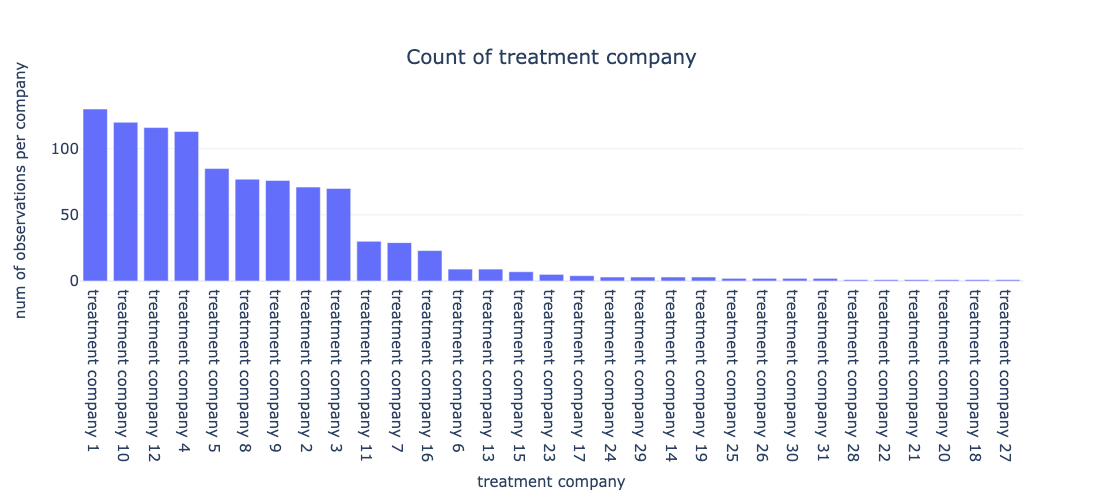

In [8]:
# treatment company
plot_df = df.copy()
plot_df["Observations"] = np.ones(len(plot_df))
plot_df = plot_df.groupby(["treatment company"]).Observations.sum().reset_index()
plot_df = plot_df.sort_values("Observations", ascending = False)
fig = px.bar(plot_df, x = "treatment company",y="Observations", title="Count of treatment company")
fig = format_plot(fig, ylabel="num of observations per company", xlabel = "treatment company")
fig.show()

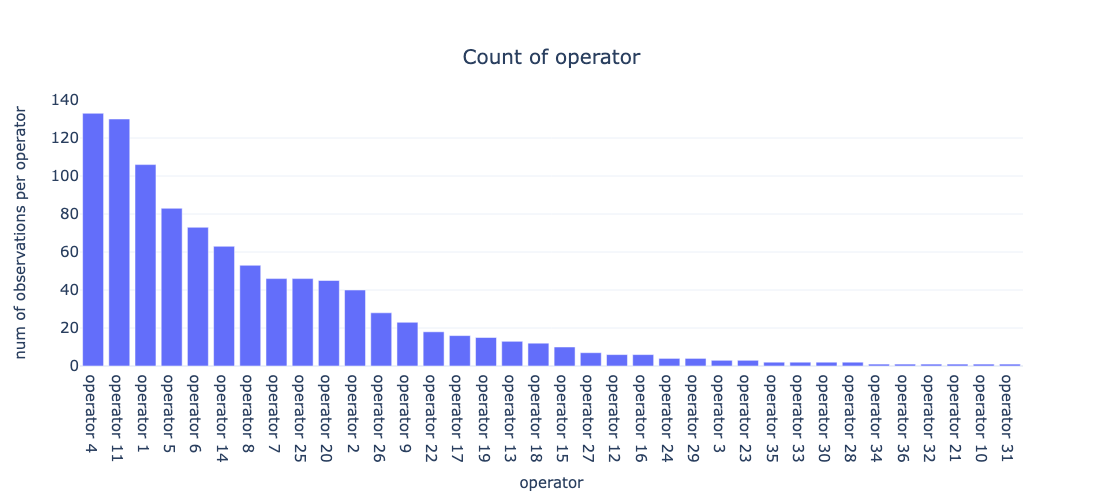

In [9]:
# operator
plot_df = df.copy()
plot_df["Observations"] = np.ones(len(plot_df))
plot_df = plot_df.groupby(["operator"]).Observations.sum().reset_index()
plot_df = plot_df.sort_values("Observations", ascending = False)
fig = px.bar(plot_df, x = "operator",y="Observations", title="Count of operator")
fig = format_plot(fig, ylabel="num of observations per operator", xlabel = "operator")
fig.show()

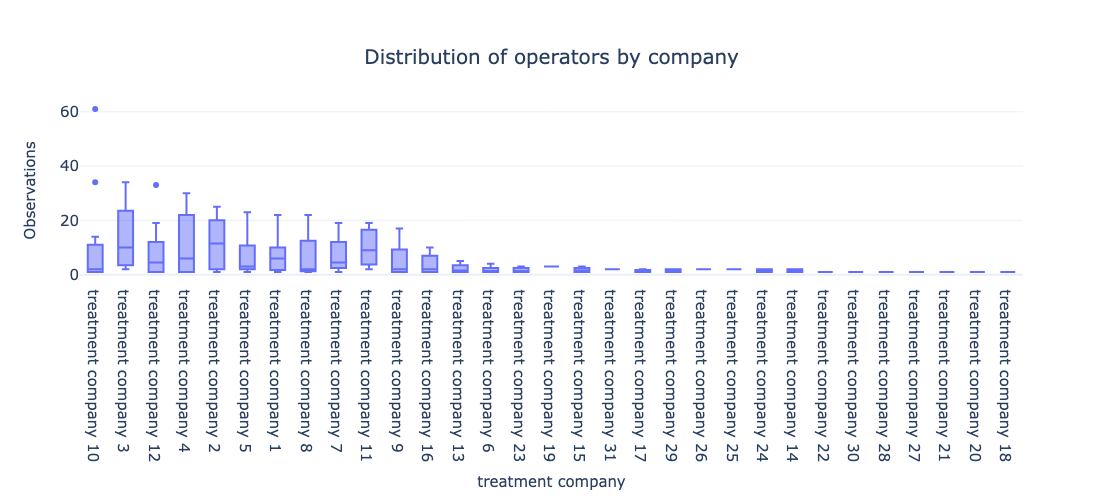

In [10]:
# operators by company
plot_df = df.copy()
plot_df["Observations"] = np.ones(len(plot_df))
plot_df = plot_df.groupby(["treatment company","operator"]).Observations.sum().reset_index()
plot_df = plot_df.sort_values("Observations", ascending = False)
fig = px.box(plot_df, x = "treatment company",y="Observations", title="Distribution of operators by company")
fig = format_plot(fig, ylabel="Observations", xlabel = "treatment company")
fig.show()

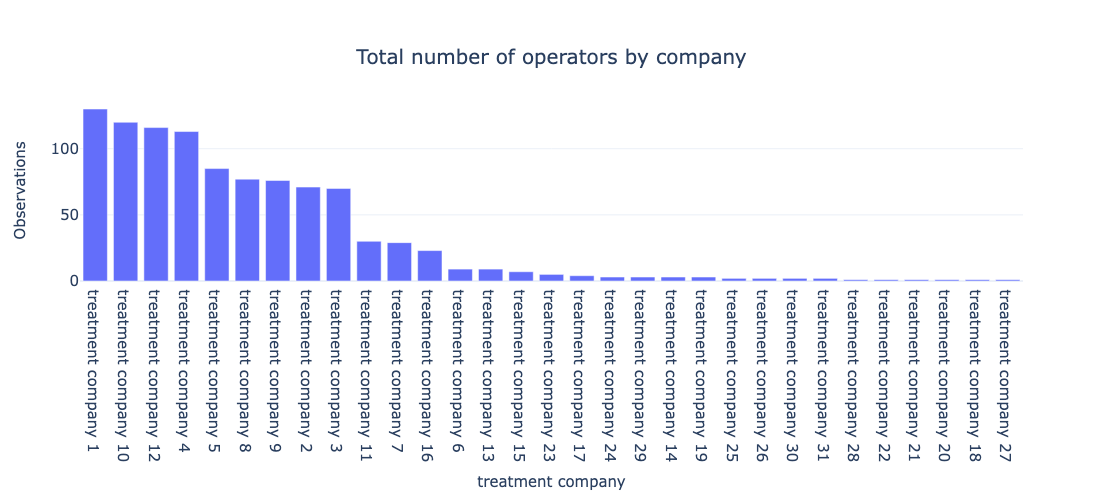

In [11]:
# total number of operators by company
plot_df = df.copy()
plot_df["Observations"] = np.ones(len(plot_df))
plot_df = plot_df.groupby(["treatment company","operator"]).Observations.sum().reset_index()
plot_df = plot_df.groupby(["treatment company"]).Observations.sum().reset_index()
plot_df = plot_df.sort_values("Observations", ascending = False)
fig = px.bar(plot_df, x = "treatment company",y="Observations", title="Total number of operators by company")
fig = format_plot(fig, ylabel="Observations", xlabel = "treatment company")
fig.show()

# Inspect the dates on production

In [12]:
# make object columns numerical
df["treatment company"] = [int(i[17:]) for i in df["treatment company"]]
df["operator"] = [int(i[8:]) for i in df["operator"]]
df = df.rename(columns = {"treatment company":"treatment_company"})

In [13]:
tc_date_list = []
for tc in df["treatment_company"].unique():
    tc_df = df.query("treatment_company == @tc")
    min_date = tc_df["date on production"].min()
    max_date = tc_df["date on production"].max()
    diff_dates = tc_df["date on production"].nunique()
    length = tc_df.shape[0]
    tc_date_list.append([tc,min_date,max_date,diff_dates,length])

pd.DataFrame(tc_date_list, columns = ["company","min_date","max_date","diff_dates","Len"]).sort_values("min_date")

company   min_date   max_date  diff_dates  Len
0        12 2011-01-01 2019-01-03          32  116
1        28 2011-01-01 2011-01-01           1    1
2         1 2011-01-01 2019-01-03          48  130
3         8 2011-01-01 2017-01-01          35   77
4         2 2011-01-01 2016-01-06          18   71
5         9 2011-01-01 2019-01-03          37   76
6        13 2011-01-01 2015-01-01           5    9
7        11 2011-01-01 2016-01-09          20   30
8        10 2011-01-07 2018-01-12          44  120
9         5 2011-01-07 2019-01-04          31   85
10       18 2011-01-07 2011-01-07           1    1
11        7 2011-01-11 2016-01-07          20   29
12        4 2012-01-01 2019-01-03          43  113
13       29 2012-01-01 2012-01-05           2    3
14       23 2012-01-01 2018-01-03           5    5
15       16 2012-01-07 2016-01-11          15   23
16       27 2012-01-09 2012-01-09           1    1
17       20 2013-01-01 2013-01-01           1    1
18       22 2013-01-01 2013-01-01           1    1
19       26 2013-01-07 2013-01-07           1    2
20       30 2013-01-12 2014-01-07           2    2
21       19 2014-01-01 2014-01-01           1    3
22        6 2014-01-07 2015-01-05           4    9
23       14 2014-01-07 2018-01-10           3    3
24        3 2014-01-08 2019-01-04          32   70
25       21 2015-01-04 2015-01-04           1    1
26       17 2015-01-08 2018-01-09           3    4
27       15 2015-01-09 2016-01-06           6    7
28       31 2016-01-07 2016-01-07           1    2
29       25 2017-01-12 2017-01-12           1    2
30       24 2018-01-07 2018-01-10           3    3

In [14]:
# take the comnpanies with the most appearences on the dataset
top_companies = [1,10,12]
top_comp_frame = df[df["treatment_company"].isin(top_companies)].reset_index()
# check how many different dates the company has vs the appearences in the dataset
for comp in top_companies:
    comp_frame = top_comp_frame.query("treatment_company == @comp")
    unique_dates = comp_frame["date on production"].nunique()
    len_comp = comp_frame.shape[0]
    print(f"{comp} has {unique_dates} unique dates and a length of {len_comp}")

1 has 48 unique dates and a length of 130
10 has 44 unique dates and a length of 120
12 has 32 unique dates and a length of 116


## Inspect production by company and operator

In [15]:
df["year"] = df["date on production"].dt.year

In [16]:
query_df = df.copy()
query_df["Observations"] = np.ones(len(query_df))
query_df = query_df.groupby(["treatment_company"]).Observations.sum().reset_index()
query_df = query_df.sort_values("Observations", ascending = False)
top_companies = query_df.query("Observations > 29")["treatment_company"].to_list()
top_companies

[1, 10, 12, 4, 5, 8, 9, 2, 3, 11]

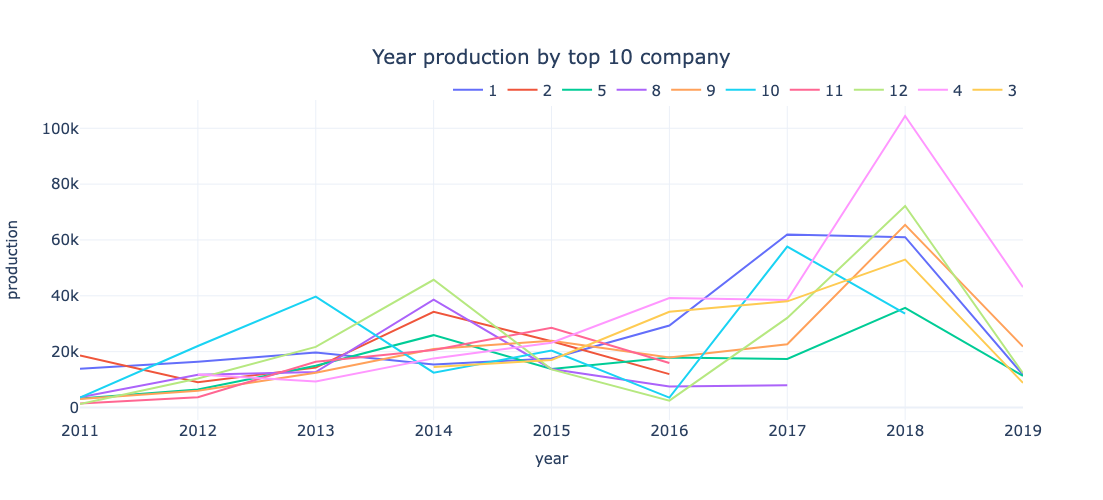

In [17]:
plot_df = df[["production", "year", "treatment_company"]]
plot_df = plot_df[plot_df.treatment_company.isin(top_companies)]
plot_df = plot_df.groupby(["year", "treatment_company"]).production.sum().reset_index()
fig = px.line(
    plot_df[["production", "year", "treatment_company"]], 
    y="production", 
    x="year",
    color="treatment_company", 
    title=f"Year production by top {len(top_companies)} company"
)
fig = format_plot(fig, ylabel="production", xlabel="year", legends=False)
fig.update_layout(showlegend=True) 
fig.show()

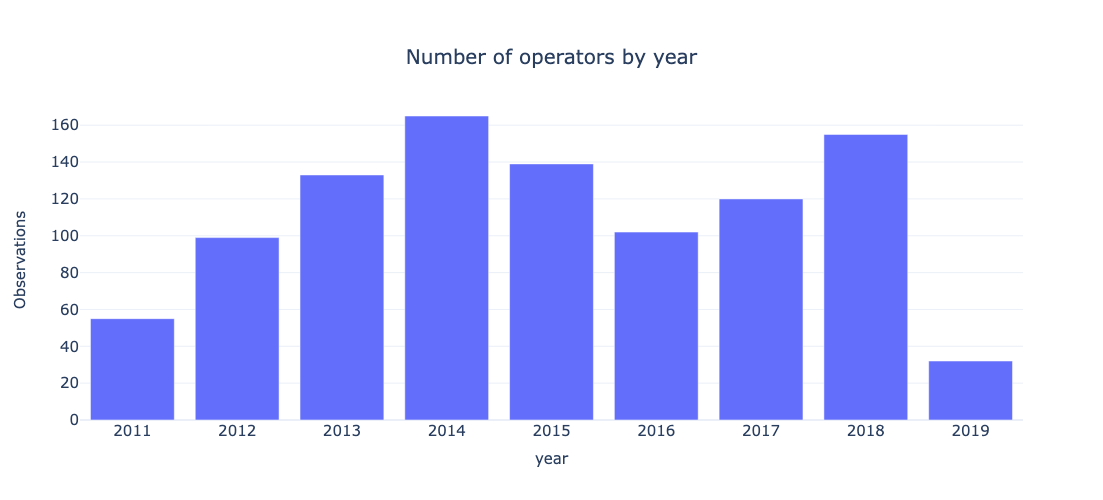

In [18]:
plot_df = df.copy()
plot_df["Observations"] = np.ones(len(plot_df))
plot_df = plot_df.groupby(["year"]).Observations.sum().reset_index()
fig = px.bar(
    plot_df[["Observations", "year"]], 
    y="Observations", 
    x="year",
    title=f"Number of operators by year"
)
fig = format_plot(fig, ylabel="Observations", xlabel="year", legends=False)
fig.update_layout(showlegend=False) 
fig.show()

# Heatmap of variables

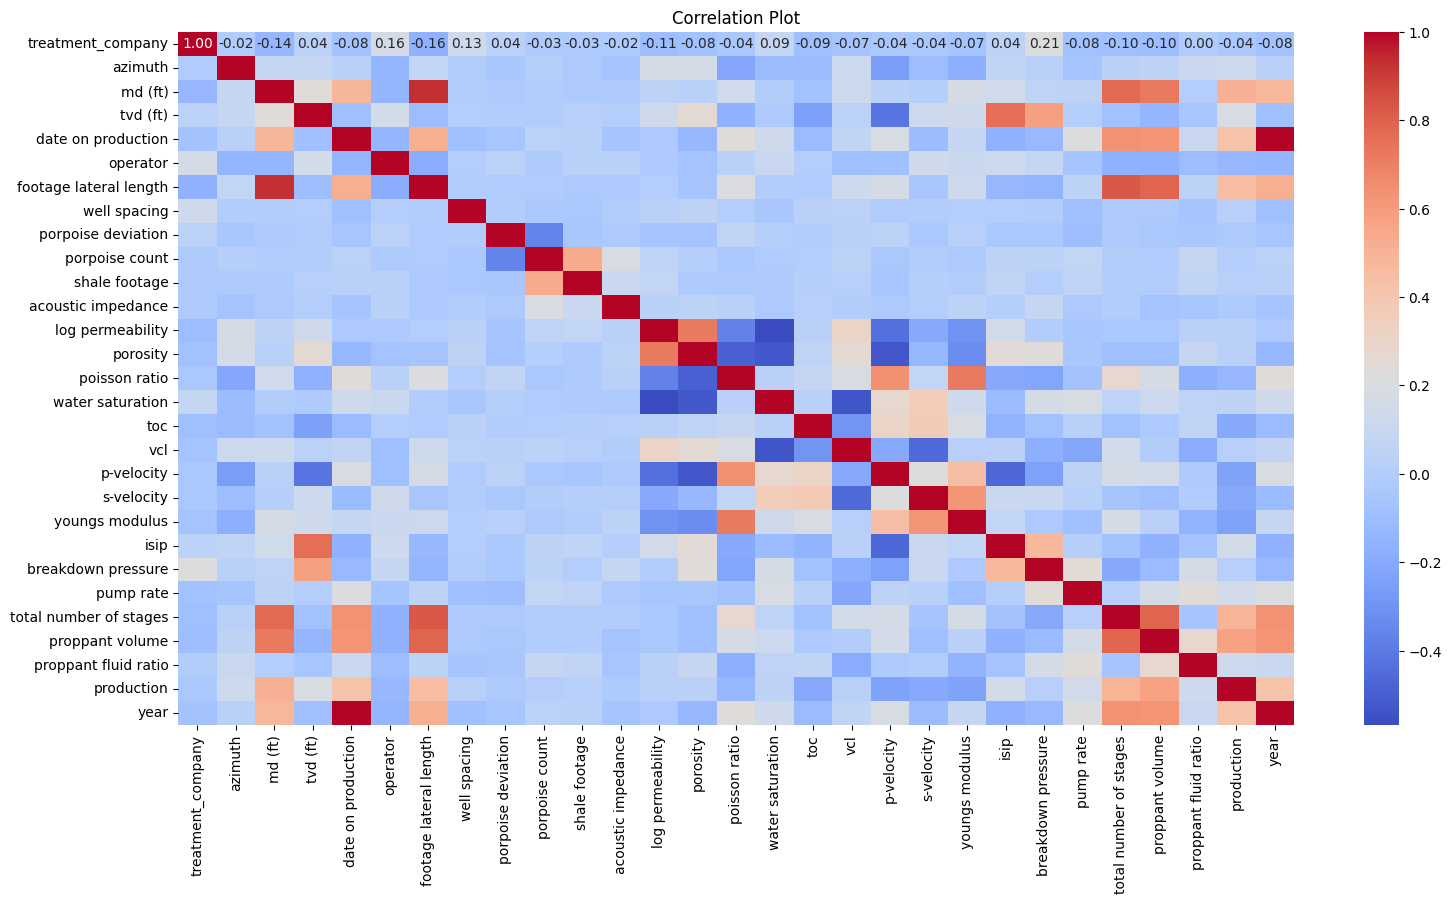

In [19]:
# Computing linear relationships of variables
correlation_matrix = df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Plot")
plt.show()

# Inspect the different types of variables

In [20]:
float_features = [i for i in df.columns if df[i].dtype == 'float64']
int_features = [i for i in df.columns if df[i].dtype == 'int64']

## float features

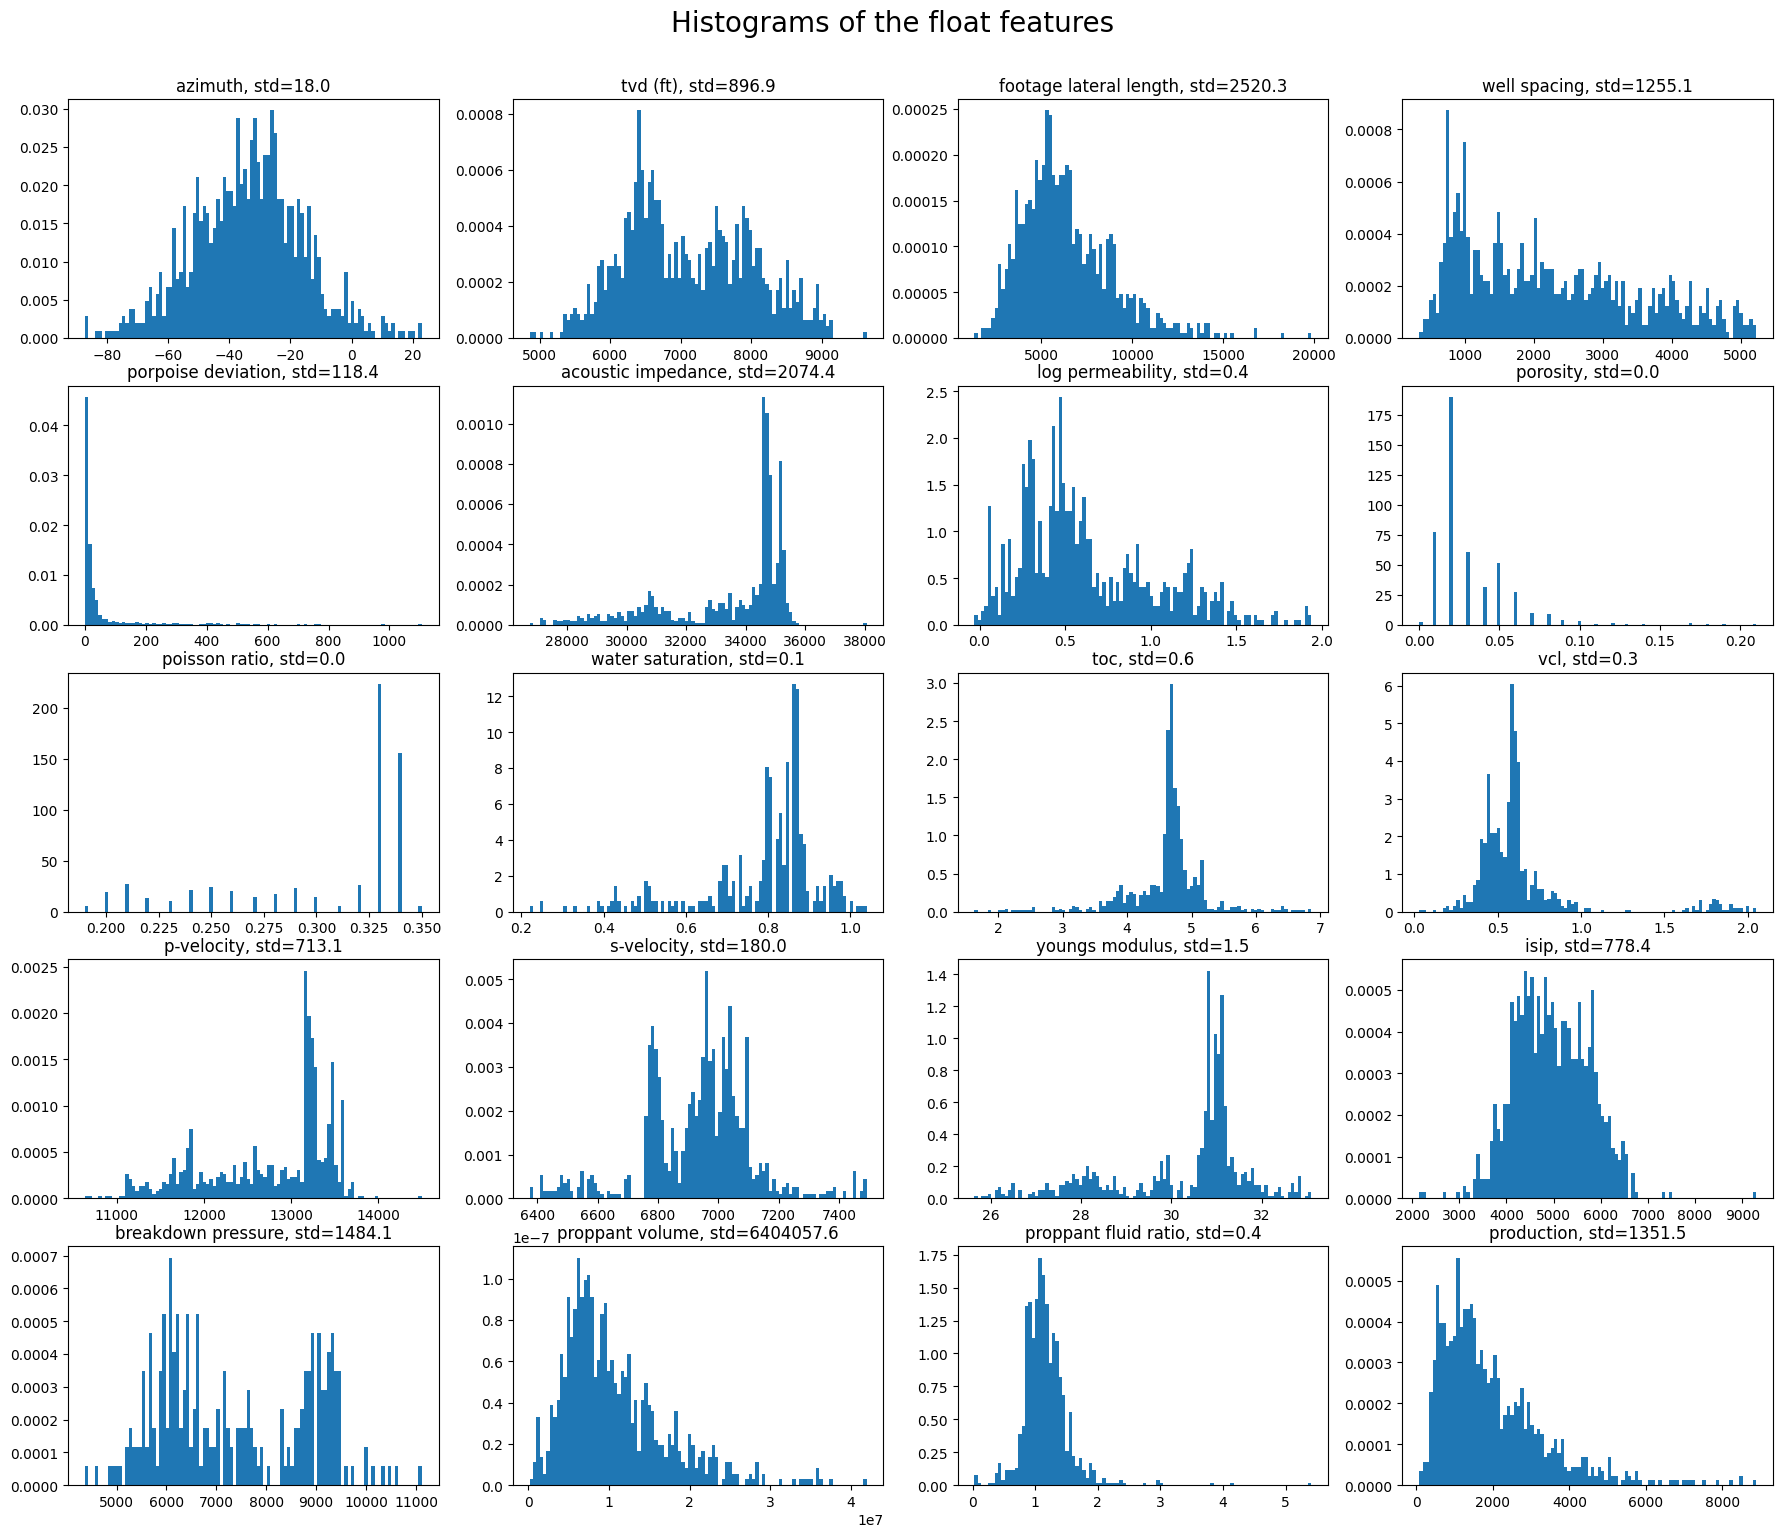

In [21]:
fig, axs = plt.subplots(5, 4, figsize=(22, 18))
for f, ax in zip(float_features, axs.ravel()):
    ax.hist(df[f], density=True, bins=100)
    ax.set_title(f'{f}, std={df[f].std():.1f}')
plt.suptitle('Histograms of the float features', y=0.93, fontsize=20)
plt.show()

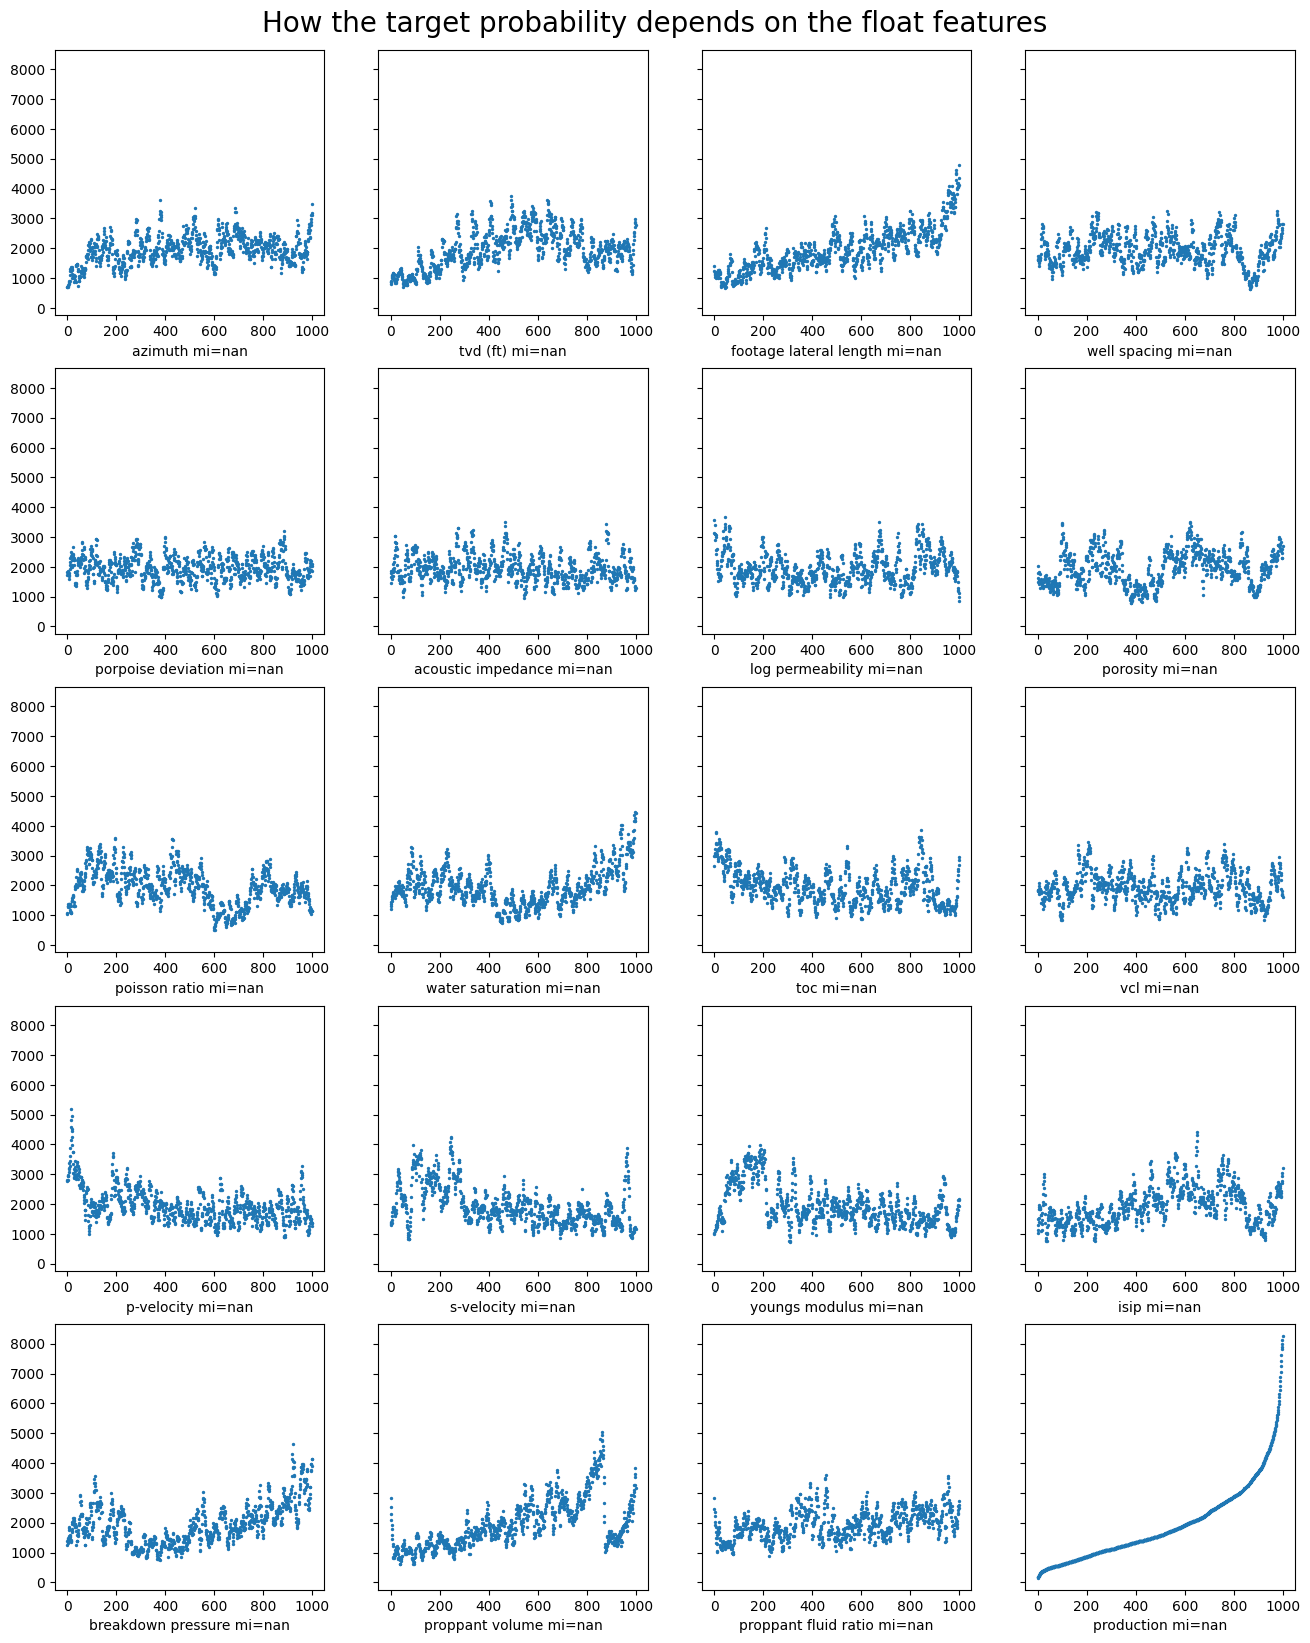

In [22]:
# Plot dependence between every feature and the target
def plot_mutual_info_diagram(df, features, ncols=4, by_quantile=True, mutual_info=True, title_pos = 0.9,
                             title='How the target probability depends on single features'):
    def H(p):
        """Entropy of a binary random variable in nat"""
        return -np.log(p) * p - np.log(1-p) * (1-p)
                 
    nrows = (len(features) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows*4), sharey=True)
    for f, ax in zip(features, axs.ravel()):
        temp = pd.DataFrame({f: df[f].values,
                             'state': df.production.values})
        temp = temp.sort_values(f)
        temp.reset_index(inplace=True)
        rolling_mean = temp.state.rolling(10, center=True, min_periods=1).mean()
        if by_quantile:
            ax.scatter(temp.index, rolling_mean, s=2)
        else:
            ax.scatter(temp[f], rolling_mean, s=2)
        if mutual_info and by_quantile:
            ax.set_xlabel(f'{f} mi={H(temp.state.mean()) - H(rolling_mean[~rolling_mean.isna()].values).mean():.5f}')
        else:
            ax.set_xlabel(f'{f}')
    plt.suptitle(title, y=title_pos, fontsize=20)
    plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    plot_mutual_info_diagram(df, float_features, title_pos = 0.9,
                             title='How the target probability depends on the float features')

## integer features

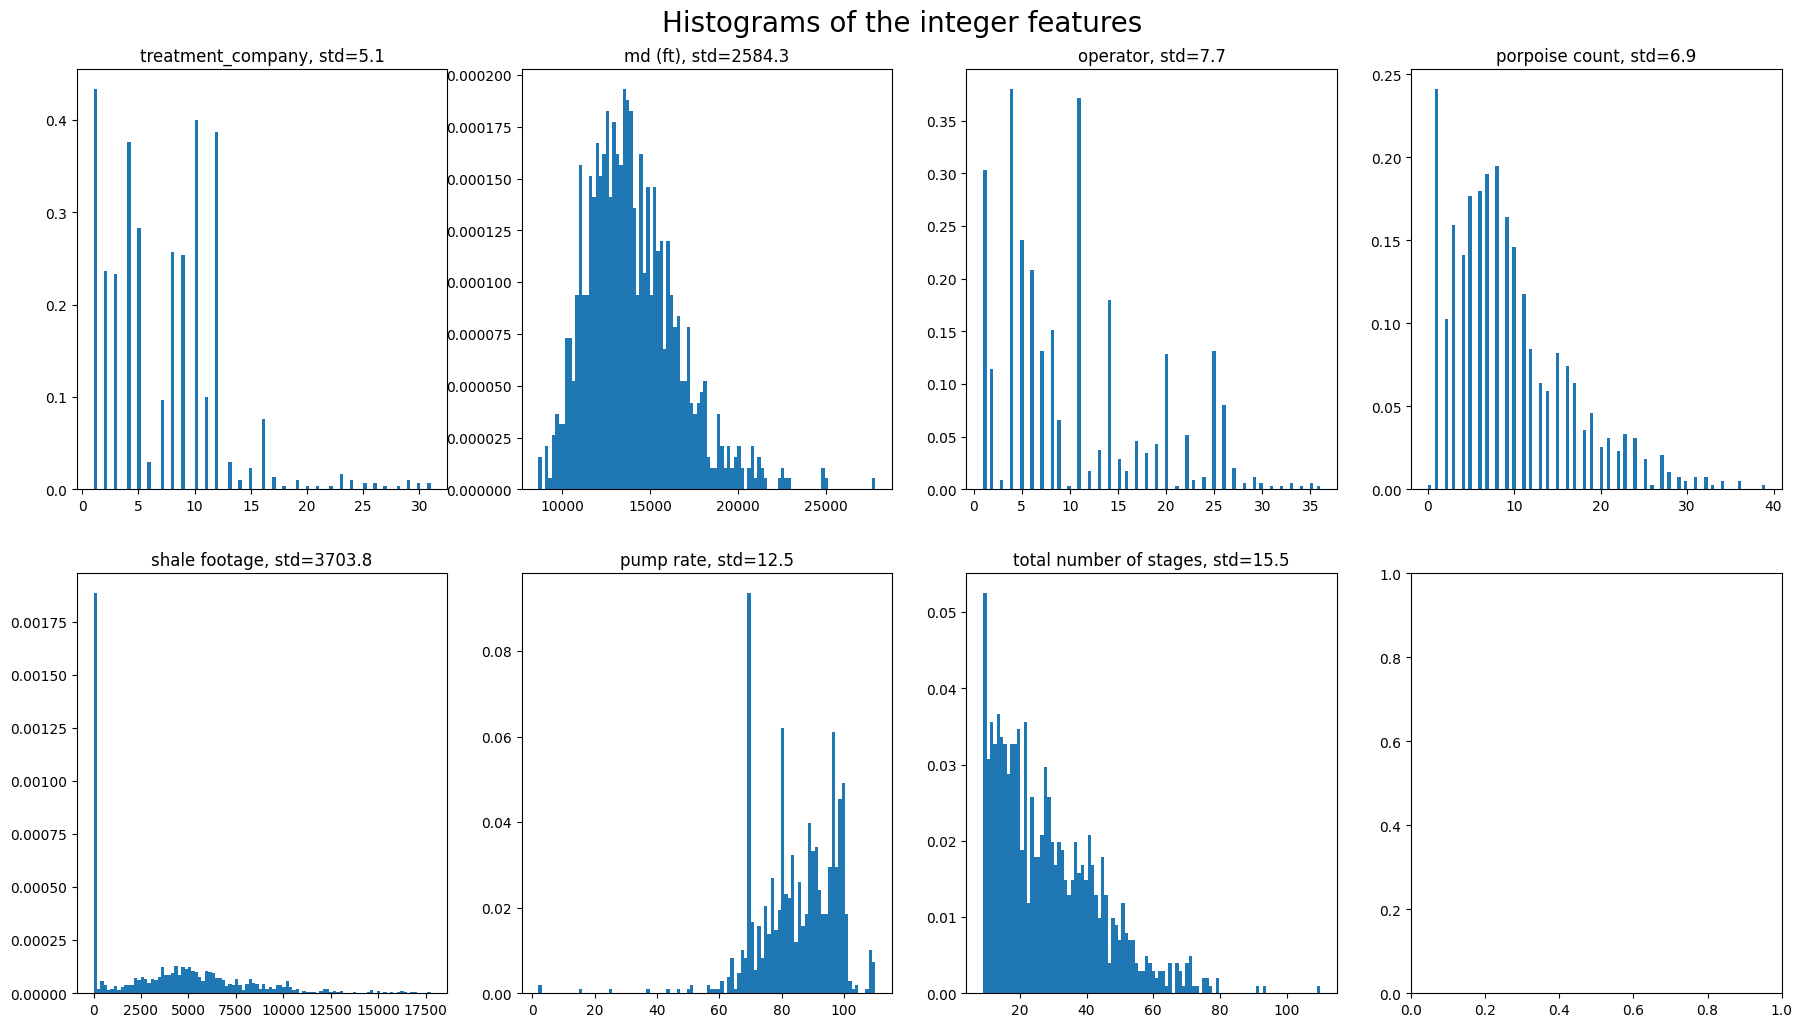

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(22, 12))
for f, ax in zip(int_features, axs.ravel()):
    ax.hist(df[f], density=True, bins=100)
    ax.set_title(f'{f}, std={df[f].std():.1f}')
plt.suptitle('Histograms of the integer features', y=0.93, fontsize=20)
plt.show()

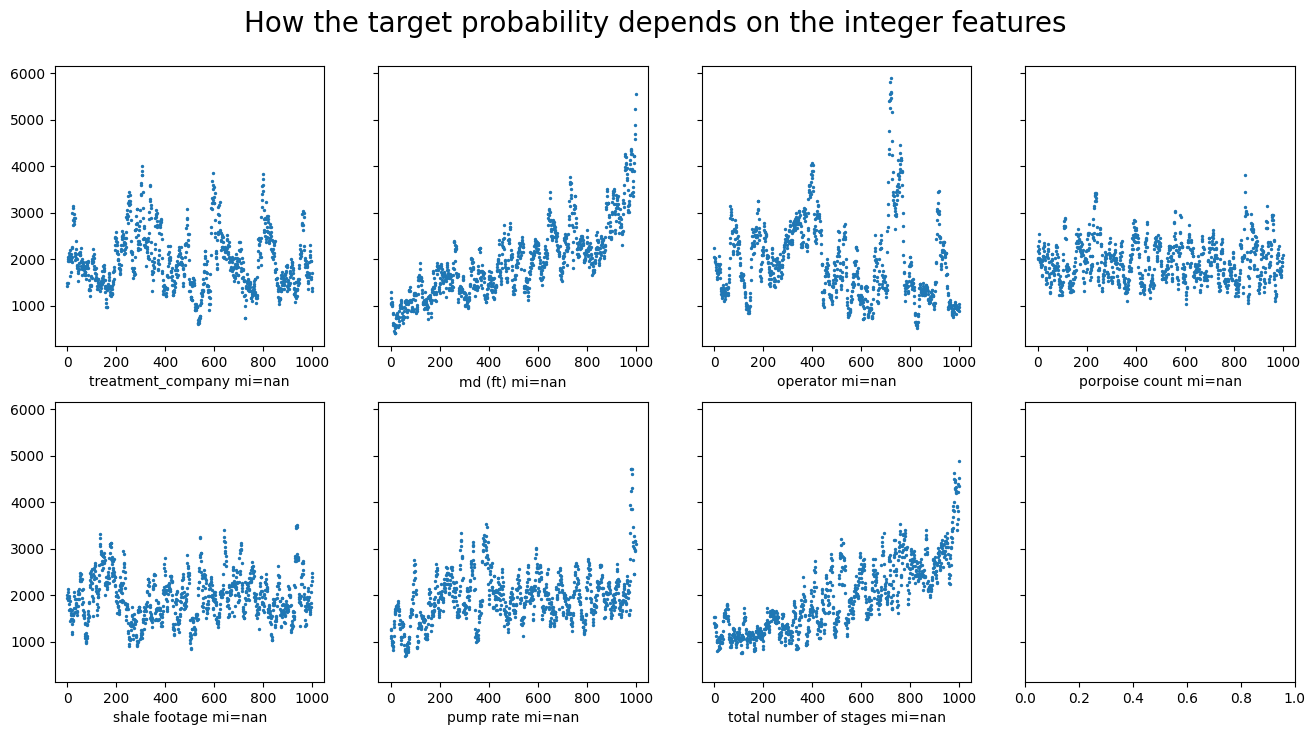

In [24]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    plot_mutual_info_diagram(df, int_features, title_pos = 0.95,
                             title='How the target probability depends on the integer features')

# feature selection

In [25]:
top_feats = ["treatment_company","operator","md (ft)","year","footage lateral length", "total number of stages","azimuth",
             "poisson ratio","toc","p-velocity","youngs modulus",
             "proppant volume","tvd (ft)","isip","pump rate","proppant fluid ratio",
             "water saturation","production"]
df = df[top_feats]
print(df.shape)
df = df.sort_values(["year","treatment_company","operator"]).reset_index(drop = True)
df.head(40)

(1000, 18)


treatment_company  operator  md (ft)  year  footage lateral length  \
0                   1         9    12810  2011                6332.000   
1                   1        20    14390  2011                6050.000   
2                   1        20    14578  2011                5342.000   
3                   1        20    13963  2011                5586.000   
4                   1        20    13746  2011                5375.000   
5                   1        20    13749  2011                5405.000   
6                   1        20    13798  2011                4950.000   
7                   1        20    14496  2011                5694.000   
8                   1        20    13948  2011                5553.000   
9                   1        20    15011  2011                6586.000   
10                  1        20    13014  2011                4581.000   
11                  1        20    13096  2011                4816.000   
12                  1        36    10491  2011                4257.000   
13                  2         2    12095  2011                5511.000   
14                  2         2    11518  2011                5057.000   
15                  2         2    11720  2011                5198.000   
16                  2         2    11150  2011                4775.000   
17                  2         2    11842  2011                5725.000   
18                  2         2    13190  2011                4747.000   
19                  2         2    13036  2011                4623.000   
20                  2         2    10965  2011                4711.000   
21                  2         2    13670  2011                5321.000   
22                  2         2    10218  2011                3703.000   
23                  2         2    13215  2011                4746.000   
24                  2         2    10770  2011                4453.000   
25                  2         2    11909  2011                3635.000   
26                  2         2    12378  2011                6029.000   
27                  2         2    10367  2011                3849.000   
28                  2        20    13373  2011                4543.000   
29                  2        20    14028  2011                5112.000   
30                  2        20    15571  2011                6652.000   
31                  5         8    10660  2011                2157.000   
32                  5         8    12300  2011                4305.000   
33                  5         8    13266  2011                4923.000   
34                  5         8    10100  2011                2124.000   
35                  7        11    14328  2011                5480.000   
36                  8         2    13850  2011                5469.000   
37                  8        23    11000  2011                4663.000   
38                  8        23    12517  2011                5747.000   
39                  8        23    12733  2011                6273.000   

    total number of stages  azimuth  poisson ratio   toc  p-velocity  \
0                       21  -29.190          0.340 4.780   13483.440   
1                       16  -30.220          0.290 6.080   11723.420   
2                       14  -19.180          0.290 6.050   11698.260   
3                       15  -51.960          0.300 5.990   11761.440   
4                       14  -42.240          0.330 4.690   13269.060   
5                       14  -31.940          0.300 6.050   11849.130   
6                       12      NaN          0.280 4.100   11777.740   
7                       14  -47.260          0.300   NaN   12047.230   
8                       14  -47.550          0.290 5.950   11644.360   
9                       16  -46.220          0.290 5.740   11667.790   
10                      19  -45.760          0.300 6.430   12322.490   
11                      12  -49.510          0.300 6.380   12261.060   
12                      20  -30.0

## water saturation analysis

water saturation is a feature that has a slight non linear dependency on the target so it is worth checking the behaviour of it and its many missing values 

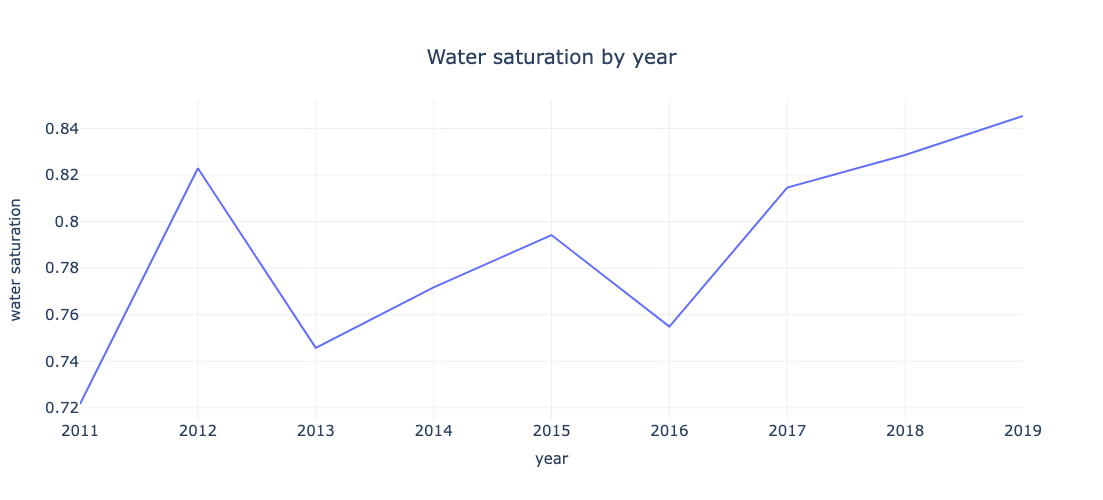

In [26]:
plot_df = df[["water saturation", "year"]]
plot_df = plot_df.groupby(["year"])["water saturation"].mean().reset_index()
fig = px.line(
    plot_df[["year", "water saturation"]], 
    y="water saturation", 
    x="year",
    title=f"Water saturation by year"
)
fig = format_plot(fig, ylabel="water saturation", xlabel="year", legends=False)
fig.update_layout(showlegend=False) 
fig.show()

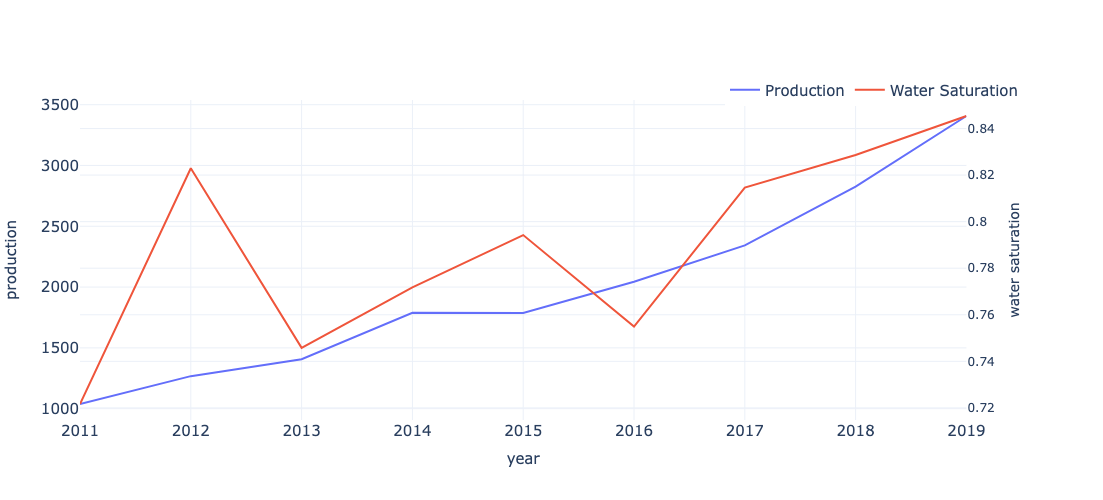

In [27]:
plot_df1 = df[["production", "year"]]
plot_df1 = plot_df1.groupby(["year"])["production"].mean().reset_index()

plot_df2 = df[["water saturation", "year"]]
plot_df2 = plot_df2.groupby(["year"])["water saturation"].mean().reset_index()

# Create a subplot with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces for variable1 and variable2
fig.add_trace(
    go.Scatter(x=plot_df1.year, y=plot_df1.production, mode='lines', name='Production'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=plot_df2.year, y=plot_df2["water saturation"], mode='lines', name='Water Saturation'),
    secondary_y=True,
)

fig = format_plot(fig, ylabel="Comparison water saturation vs production over time", xlabel = "year")

# Update y-axes labels
fig.update_yaxes(title_text="production", secondary_y=False)
fig.update_yaxes(title_text="water saturation", secondary_y=True)

# Show plot
fig.show()

Clearly a realtionship can be seen between these two variables 

# treatment company vs production

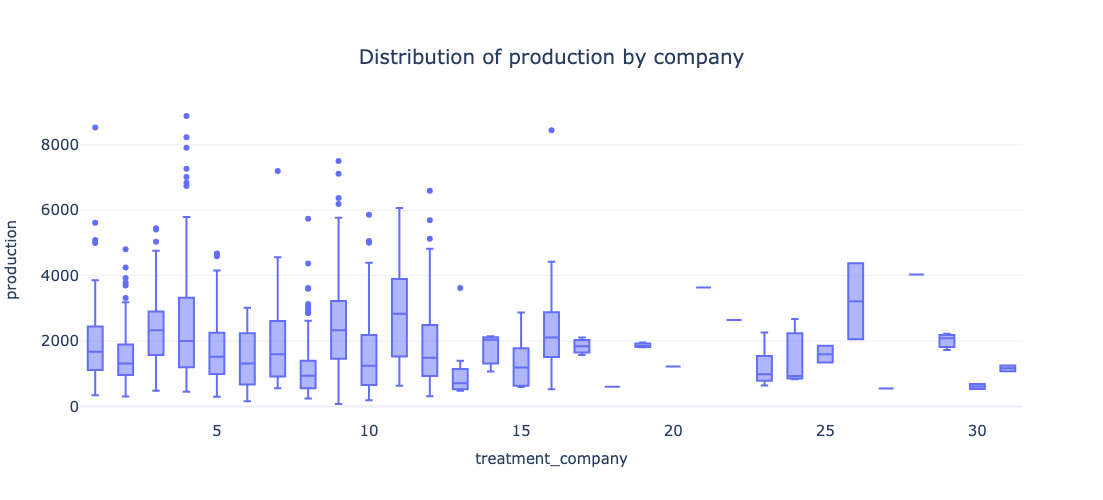

In [28]:
plot_df = df[["treatment_company","production"]]
fig = px.box(plot_df, x = "treatment_company",y="production", title="Distribution of production by company")
fig = format_plot(fig, ylabel="production", xlabel = "treatment_company")
fig.show()

In [29]:
sum_df = df[["treatment_company","year","production"]]
sum_df = pd.pivot_table(df, values='production', index=['year'],columns=['treatment_company'], aggfunc="mean")
sum_df.describe().T

count     mean      std      min      25%      50%  \
treatment_company                                                       
1                  9.000 1906.749  730.757 1064.833 1172.922 1924.603   
2                  6.000 1576.063  415.058 1035.629 1346.989 1502.345   
3                  6.000 2341.752  530.593 1699.608 1931.184 2330.372   
4                  8.000 2434.540 1185.901 1480.882 1665.009 2015.255   
5                  9.000 1711.947  660.200  798.536 1152.589 1726.014   
6                  2.000 1677.571  823.841 1095.027 1386.299 1677.571   
7                  6.000 2264.309 1139.867 1043.386 1419.946 2085.200   
8                  7.000 1186.864  352.976  836.894  946.180 1073.246   
9                  9.000 2414.522  916.428 1027.866 1841.792 2486.732   
10                 8.000 1540.120  668.321  879.570 1048.623 1347.283   
11                 6.000 2565.806 1310.206  729.247 1629.997 3024.436   
12                 9.000 1900.331  693.247 1137.976 1255.634 1735.010   
13                 4.000 1448.493 1457.232  534.553  713.622  817.462   
14                 3.000 1751.843  592.442 1070.739 1553.904 2037.068   
15                 2.000 1256.269  600.070  831.955 1044.112 1256.269   
16                 4.000 2992.325 1763.694 1792.160 2145.705 2281.021   
17                 3.000 1776.283  234.081 1575.182 1647.804 1720.426   
18                 1.000  602.466      NaN  602.466  602.466  602.466   
19                 1.000 1868.129      NaN 1868.129 1868.129 1868.129   
20                 1.000 1220.963      NaN 1220.963 1220.963 1220.963   
21                 1.000 3633.961      NaN 3633.961 3633.961 3633.961   
22                 1.000 2645.711      NaN 2645.711 2645.711 2645.711   
23                 4.000 1221.414  724.131  643.738  788.383  989.427   
24                 1.000 1479.197      NaN 1479.197 1479.197 1479.197   
25                 1.000 1600.513      NaN 1600.513 1600.513 1600.513   
26                 1.000 3214.951      NaN 3214.951 3214.951 3214.951   
27                 1.000  551.719      NaN  551.719  551.719  551.719   
28                 1.000 4036.422      NaN 4036.422 4036.422 4036.422   
29                 1.000 2012.733      NaN 2012.733 2012.733 2012.733   
30                 2.000  608.338  109.084  531.204  569.771  608.338   
31                 1.000 1167.038      NaN 1167.038 1167.038 1167.038   

                       75%      max  
treatment_company                    
1                 2257.533 2933.302  
2                 1858.737 2143.322  
3                 2794.328 2943.063  
4                 2581.127 4784.155  
5                 2272.212 2484.602  
6                 1968.842 2260.114  
7                 2894.624 4009.443  
8                 1374.277 1756.996  
9                 2981.735 3775.174  
10                1887.320 2745.084  
11                3252.358 4123.202  
12                2444.702 3067.122  
13                1552.333 3624.497  
14                2092.395 2147.721  
15                1468.425 1680.582  
16                3127.641 5615.097  
17                1876.833 2033.239  
18                 602.466  602.466  
19                1868.129 1868.129  
20                1220.963 1220.963  
21                3633.961 3633.961  
22                2645.711 2645.711  
23                1422.458 2263.065  
24                1479.197 1479.197  
25                1600.513 1600.513  
26                3214.951 3214.951  
27                 551.719  551.719  
28                4036.422 4036.422  
29                2012.733 2012.733  
30                 646.905  685.471  
31                1167.038 1167.038

# Analysis of selected float features

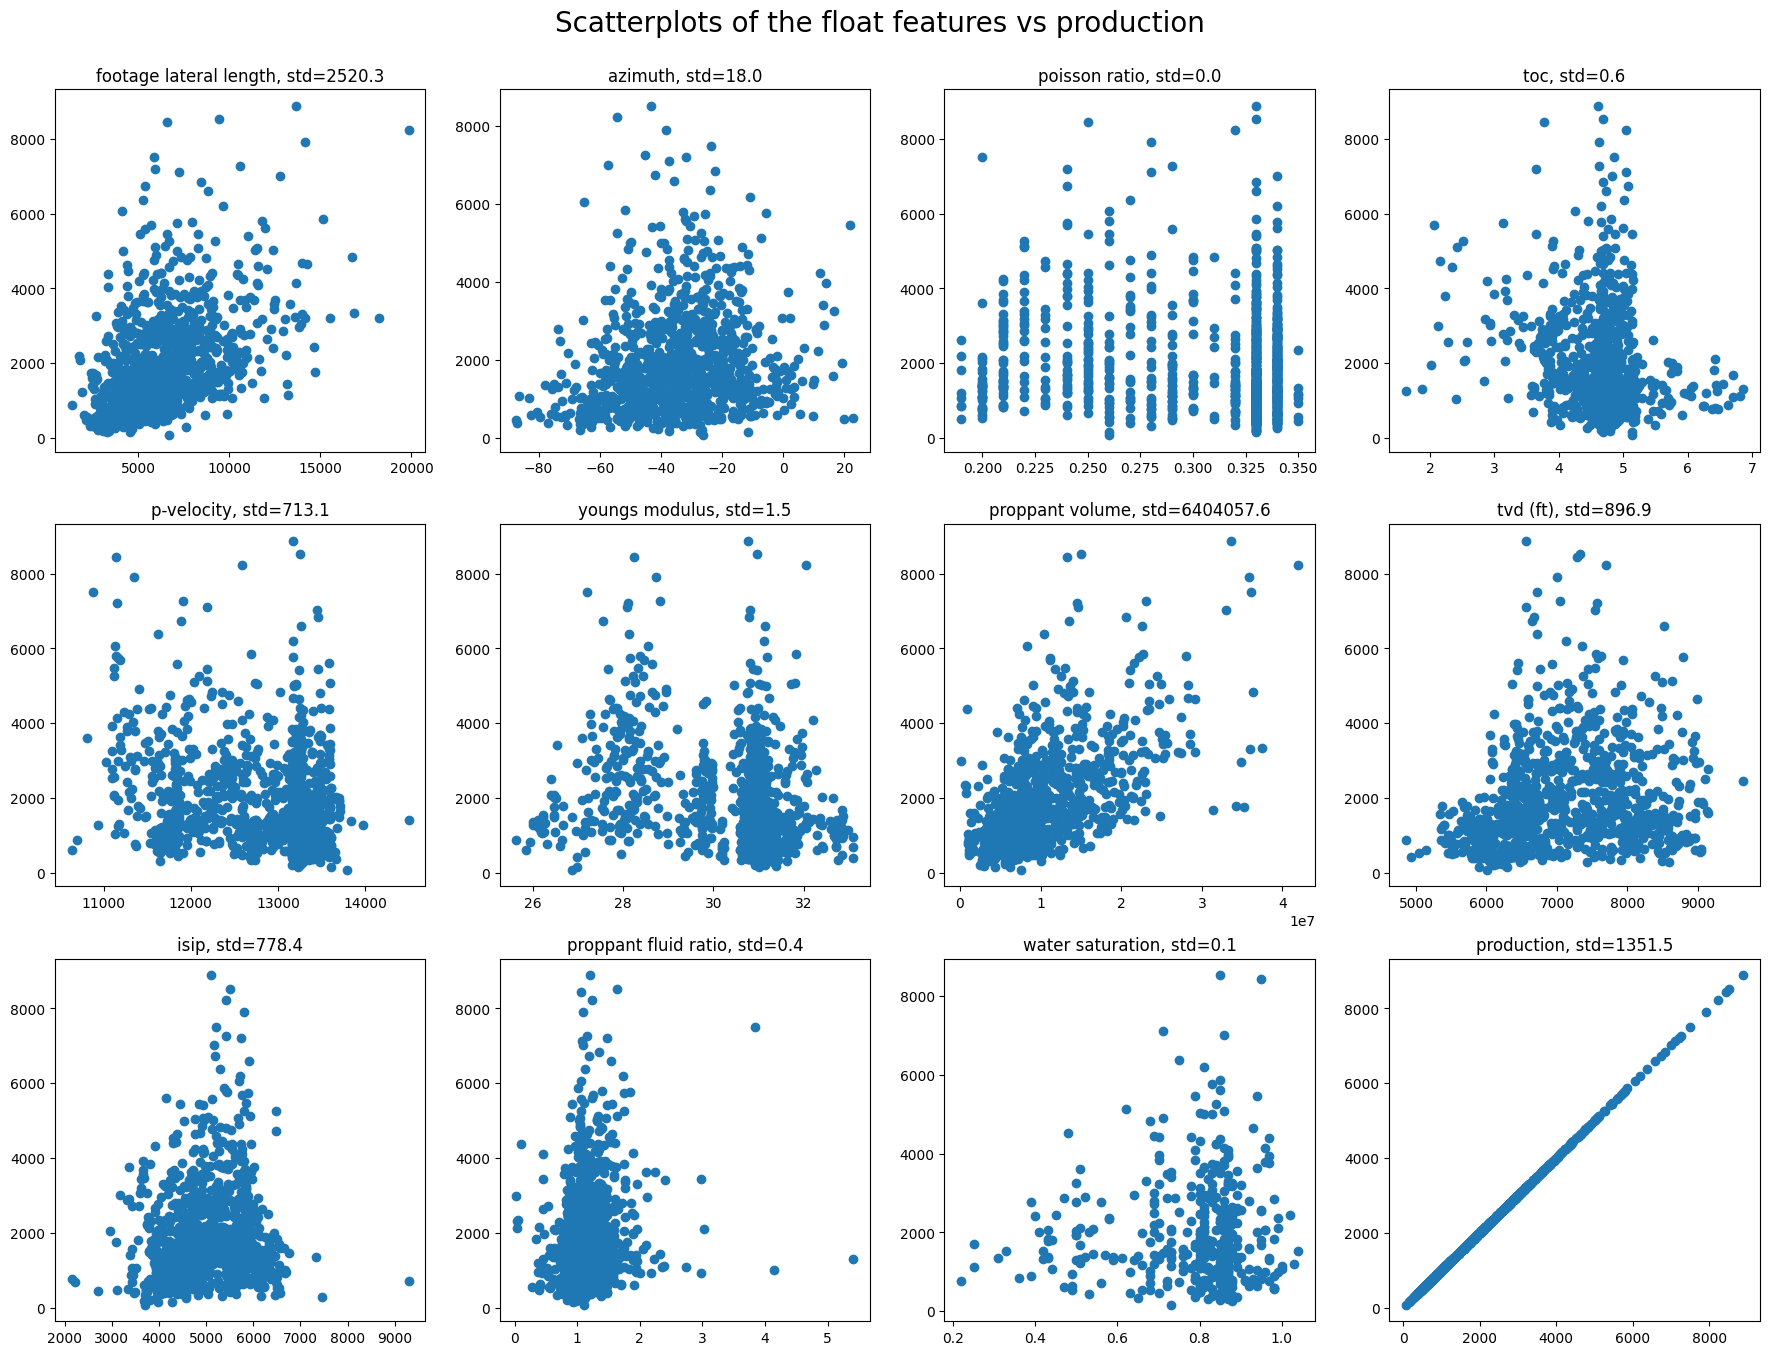

In [30]:
float_features = [i for i in df.columns if df[i].dtype == 'float64']
fig, axs = plt.subplots(3, 4, figsize=(22, 16))
for f, ax in zip(float_features, axs.ravel()):
    ax.scatter(x = df[f], y = df.production)
    ax.set_title(f'{f}, std={df[f].std():.1f}')
plt.suptitle('Scatterplots of the float features vs production', y=0.93, fontsize=20)
plt.show()

# Target distribution

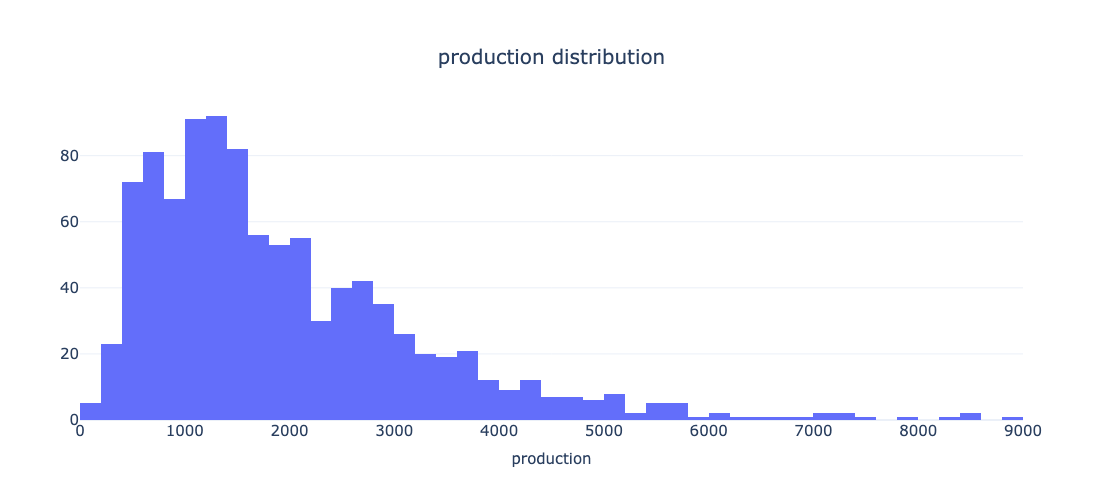

In [31]:
fig = px.histogram(
    df["production"], 
    title=f"production distribution"
)
fig = format_plot(fig, ylabel=None, xlabel="production", legends=False)
fig.update_layout(showlegend=False) 
fig.show()

# Notes

Because of the lack of different dates, the problem will be tackled as a regression task where the goal is to predict production for any existing or new company given a set of features.

Only the selected variables will be used for training

treatment company will not be used as a feature because what the model will try to predict is the production independent of the treatment company, and because there are some treatment companies that only appear once in the dataset

Next steps:
* Data split
* imputation of missing values
* feature engineering
* modelling